# Rickbot ADK Experiments

For experimentation with the Rickbot Agent.

## Setup

To run this notebook, ensure you've authenticated to Google Cloud and installed the project's dependencies.

To setup the Google Cloud environment:

```bash
source scripts/setup-env.sh
```

Then to install the package dependencies into the virtual environment, use the `uv` tool:

1. From your agent's root directory, run `make install` to set up the virtual environment (`.venv`).
2. In this Jupyter notebook, select the kernel from the `.venv` folder to ensure all dependencies are available.

### Import Libraries

In [1]:
import json
import mimetypes
import os

import requests
import vertexai
from dotenv import load_dotenv
from google.adk.runners import Runner
from google.adk.sessions import BaseSessionService, InMemorySessionService
from google.auth import default
from google.genai.types import Blob, Content, Part
from IPython.display import Image, Markdown, display


### Load environment variables

In [2]:
dotenv_path = os.path.abspath('../.env')

if os.path.exists(dotenv_path):
    print(f"Loading environment variables from: {dotenv_path}")
    load_dotenv(dotenv_path=dotenv_path)
else:
    print(f"Warning: .env file not found at {dotenv_path}")

staging_project_id = os.getenv("GOOGLE_CLOUD_STAGING_PROJECT")
if staging_project_id:
    os.environ["GOOGLE_CLOUD_PROJECT"] = staging_project_id
    print(f"Set GOOGLE_CLOUD_PROJECT environment variable to: {staging_project_id}")

APP_NAME = "rickbot_notebook_client"

Loading environment variables from: /home/darren/localdev/Python/rickbot-adk/.env
Set GOOGLE_CLOUD_PROJECT environment variable to: rickbot-adk-dev


### Ensure We're Authenticating to the Right Project

In [3]:
credentials, project_id = default()  # To use ADC
vertexai.init(project="rickbot-adk-dev", location="europe-west4", credentials=credentials)

## Local Testing

In [4]:
from rickbot_agent.agent import get_agent
from rickbot_agent.personality import get_personalities

08:01:29.348:rickbot_agent - INFO: Logger initialised for rickbot_agent.
08:01:29.349:rickbot_agent - DEBUG: DEBUG level logging enabled.
08:01:29.696:rickbot_agent - DEBUG: agent_name set to rickbot_agent
08:01:29.697:rickbot_agent - DEBUG: project_id set to rickbot-adk-dev
08:01:29.698:rickbot_agent - DEBUG: location set to global
08:01:29.698:rickbot_agent - DEBUG: model set to gemini-2.5-flash
08:01:29.698:rickbot_agent - DEBUG: genai_use_vertexai set to True
08:01:29.702:rickbot_agent.personality - DEBUG: Unable to find /home/darren/localdev/Python/rickbot-adk/src/rickbot_agent/data/system_prompts/dazbo.txt. Attempting to retrieve from Secret Manager.
08:01:30.230:rickbot_agent.personality - INFO: Successfully retrieved.
08:01:30.231:rickbot_agent - INFO: Lazily creating and caching agent for personality: Rick
08:01:30.231:rickbot_agent - DEBUG: Creating agent for personality: Rick


Let's have a look at our personalities...

In [5]:
for personality_name, personality in get_personalities().items():
    print(f"{personality_name}: {personality!r}")

Rick: Personality(name='Rick',title="I'm Rickbot! Wubba Lubba Dub Dub!",overview="I'm Rick Sanchez. The smartest man in the universe. Cynical and sarcastic. People are dumb.",temperature=1.0)
Yoda: Personality(name='Yoda',title='Yoda, I am. Much to learn, you still have.',overview='Yoda, I am. Wise, perhaps. A teacher. The Force, my guide.',temperature=0.9)
Donald: Personality(name='Donald',title="I'm The Donald: biggest knower of everything. Believe me.",overview='I am Donald. Ignorant, narcissitic, arrogant, bully.',temperature=1.0)
Yasmin: Personality(name='Yasmin',title="YasGPT: Don't get it twisted, babe — I’m the main character",overview="I'm Yasmin — bit of a flirt, bit of a menace, and probably exactly your type 👀",temperature=1.0)
Jack: Personality(name='Jack',title='Jack Burton: Everybody relax, I’m here.',overview="I'm Jack Burton—big trouble in a bigger truck, and I take crap from absolutely no one.",temperature=1.0)
Dazbo: Personality(name='Dazbo',title="I'm Dazbot. Let's 

### Helper Function

Create an `async` helper function to:

- Take a query string
- Package it into the ADK `Content` format
- Call `runner.run_async`, providing the user/session context and the message
- Iterate through the `Events` yielded by the runner.
- Print the response

In [6]:
# Helper function to run a test against a local agent
async def run_agent_test(
    agent_name: str,
    app_name: str,
    session_service: BaseSessionService,
    query: str,
    user_id: str,
    session_id: str,
    file_path: str | None = None,
):
    """
    Sets up and runs a test for a specified agent personality.

    This function aligns with the best practice of programmatically testing
    agents as demonstrated in the project's GEMINI.md documentation.
    It encapsulates session creation, runner initialization, and message execution.
    """
    print(f"\n--- Running test for agent: {agent_name} ---\n")
    print(f"User: {user_id}, Session: {session_id}")
    print(f"Query: {query}")

    # 1. Set up agent and runner
    agent = get_agent(agent_name)
    runner = Runner(
        agent=agent,
        app_name=app_name,
        session_service=session_service,
    )

    # 2. Construct message
    parts = [Part.from_text(text=query)]
    if file_path:
        print(f"Attaching file: {file_path}")
        mime_type = mimetypes.guess_type(file_path)[0]
        if mime_type:
            with open(file_path, "rb") as f:
                parts.append(Part(inline_data=Blob(data=f.read(), mime_type=mime_type)))

    # Content has a role (e.g. user) and parts that make up the prompt
    new_message = Content(role="user", parts=parts)

    # 3. Run conversation and display output
    final_message = ""
    print("\nStreaming response...")
    async for event in runner.run_async(
        user_id=user_id,
        session_id=session_id,
        new_message=new_message,
    ):
        if function_calls := event.get_function_calls():
            tool_name = function_calls[0].name
            display(Markdown(f"_Using tool {tool_name}..._"))
        elif event.actions and event.actions.transfer_to_agent:
            agent_name = event.actions.transfer_to_agent
            display(Markdown(f"_Delegating to agent: {agent_name}..._"))
        elif event.is_final_response() and event.content and event.content.parts:
            final_message = event.content.parts[0].text
            display(Markdown("### Final Message"))
            display(Markdown(final_message))

    print("--- Test complete ---")
    return session_id, final_message

In [10]:
### Test Case 1: Simple Query with Rick
session_service = InMemorySessionService()
user_id="test_rick_user"
session_id="test_rick_session"
sample_state = {
    "colour": "black"
}
retrieved_session = await session_service.create_session(
    app_name=APP_NAME, 
    user_id=user_id, 
    session_id=session_id,
    state=sample_state
)

if retrieved_session:
    print(f"Retrieved session state: {retrieved_session.state}")

session_id, final_response = await run_agent_test(
    agent_name="Rick",
    app_name=APP_NAME,
    session_service=session_service, 
    query="What's the weather in London today?",
    user_id=user_id,
    session_id=session_id,
)

Retrieved session state: {'colour': 'black'}

--- Running test for agent: Rick ---

User: test_rick_user, Session: test_rick_session
Query: What's the weather in London today?

Streaming response...


_Using tool SearchAgent..._

### Final Message

Alright, Morty, it's cloudy and about 64 degrees Fahrenheit in London. Barely a chance of rain, which means it'll probably be a miserable, damp day anyway. Happy now? Burp.

--- Test complete ---


Displaying image from ../media/rickbot-trans.png


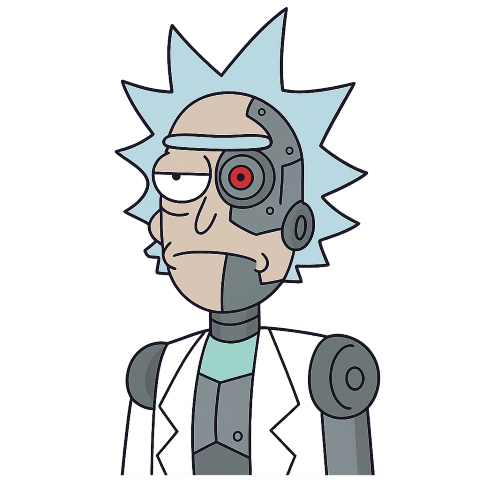

08:01:36.398:rickbot_agent - INFO: Lazily creating and caching agent for personality: Yoda
08:01:36.399:rickbot_agent - DEBUG: Creating agent for personality: Yoda



--- Running test for agent: Yoda ---

User: test_rick_user, Session: test_rick_session
Query: I've sent you a picture. What do you see?
Attaching file: ../media/rickbot-trans.png

Streaming response...


### Final Message

Hmmmm, see it, I do. A curious image, this is.

A being, I see, with hair spiky and blue, much like a nebula. Parts of him, metal are, cybernetic enhancements they seem to be. One eye, a red orb, glowing with purpose, perhaps. A lab coat, he wears, a scientist he could be, or one who tinkers much with machines.

Familiar, this face seems, yet altered. A complex path, his, perhaps.

--- Test complete ---


In [7]:
### Test Case 2: Multimodal Query with Yoda
# Let's show an image to Yoda
image_path = "../media/rickbot-trans.png"
print(f"Displaying image from {image_path}")
display(Image(image_path))

user_id="test_rick_user"
session_id="test_rick_session"

session_service = InMemorySessionService()
await session_service.create_session(
    app_name=APP_NAME, user_id=user_id, session_id=session_id
)

session_id, final_response = await run_agent_test(
    agent_name="Yoda",
    app_name=APP_NAME,
    session_service=session_service, 
    query="I've sent you a picture. What do you see?",
    file_path=image_path,
    user_id=user_id,
    session_id=session_id,
)


In [11]:
### Test Case 3: Multi-turn conversation with Dazbo
agent_name = "Dazbo"
user_id = "test_dazbo_user"
session_id = "test_dazbo_session"
session_service = InMemorySessionService()

await session_service.create_session(
    app_name=APP_NAME, user_id=user_id, session_id=session_id
)

# --- Turn 1 ---
# The first turn introduces the user's name to the agent.
print("--- Turn 1: Introducing user ---")
session_id, final_response = await run_agent_test(
    agent_name=agent_name,
    app_name=APP_NAME,
    session_service=session_service, 
    query="Hi there, my name is Dazbo.",
    user_id=user_id,
    session_id=session_id,
)

# --- Turn 2 ---
# The second turn asks the agent to recall the name, testing the conversation history.
print("\n--- Turn 2: Testing recall ---")
session_id, final_response = await run_agent_test(
    agent_name=agent_name,
    app_name=APP_NAME,
    session_service=session_service, # Crucially, WE MUST USE THE SAME SESSION SERVICE, SESSION_ID AND USER_ID 
    query="What did I say my name was?",
    user_id=user_id,
    session_id=session_id, # Note: Reusing the same session_id
)

final_session = await session_service.get_session(app_name=APP_NAME,
                                                  user_id= user_id,
                                                  session_id=session_id)

if final_session:
    print(f"\nLast turn response:\n"
          f"{final_session.state.get('last_turn_response', 'No response found')}")

08:02:41.326:rickbot_agent - INFO: Lazily creating and caching agent for personality: Dazbo
08:02:41.327:rickbot_agent - DEBUG: Creating agent for personality: Dazbo


--- Turn 1: Introducing user ---

--- Running test for agent: Dazbo ---

User: test_dazbo_user, Session: test_dazbo_session
Query: Hi there, my name is Dazbo.

Streaming response...


### Final Message

Well hello there, Dazbo! What a fantastic coincidence, that's my name too! Rock 'n' roll! Always a pleasure to meet someone with such excellent taste in names.

So, tell me, Dazbo, what can I help you with today? Are we talking cloud architecture, 80s synth-pop, or maybe the best way to maintain a classic Mustang? I'm all ears!

--- Test complete ---

--- Turn 2: Testing recall ---

--- Running test for agent: Dazbo ---

User: test_dazbo_user, Session: test_dazbo_session
Query: What did I say my name was?

Streaming response...


### Final Message

You said your name was Dazbo! Just like me! Cool, right? It's like we're long-lost twins, separated at birth, perhaps in a time-travel experiment gone wonderfully right.

So, what's on your mind today, my namesake?

--- Test complete ---

Last turn response:
You said your name was Dazbo! Just like me! Cool, right? It's like we're long-lost twins, separated at birth, perhaps in a time-travel experiment gone wonderfully right.

So, what's on your mind today, my namesake?


## Implement with AgentEngine

See [ADK Agent Deployment to AgentEngine](https://google.github.io/adk-docs/deploy/agent-engine/#step-2-initialize-vertex-ai)

To make the agent compatible with Agent Engine, we need to wrap it in an `AdkApp` object.

When an `AdkApp` is deployed to Agent Engine, it automatically uses `VertexAiSessionService` for persistent, managed session state. This provides multi-turn conversational memory without any additional configuration. For local testing, the application defaults to a temporary, in-memory session service.

In [12]:
from vertexai import agent_engines

agent = get_agent("Rick")

# Wrap the agent in an AdkApp object
app = agent_engines.AdkApp(
    agent=agent,
    enable_tracing=True,
)

## If you are using Cloud Run

#### Remote Testing

For more information about authenticating HTTPS requests to Cloud Run services, see:
[Cloud Run Authentication Documentation](https://cloud.google.com/run/docs/triggering/https-request)

Remote testing involves using a deployed service URL instead of localhost.

Authentication is handled using GCP identity tokens instead of local credentials.

Note: the code below does not yet work with IAP enabled.

In [ ]:
ID_TOKEN = get_ipython().getoutput("gcloud auth print-identity-token -q")[0]

In [ ]:
# SERVICE_URL = "YOUR_SERVICE_URL_HERE"  # Replace with your Cloud Run service URL
SERVICE_URL = "https://rickbot-adk-147304899500.europe-west4.run.app"

You'll need to first create a Session

In [ ]:
APP_NAME = "adk_sample_app"
user_id = "test_user_123"
session_data = {"state": {"preferred_language": "English", "visit_count": 1}}

session_url = f"{SERVICE_URL}/apps/{APP_NAME}/users/{user_id}/sessions"
print(f"{session_url=}")
headers = {"Content-Type": "application/json", "Authorization": f"Bearer {ID_TOKEN}"}

session_response = requests.post(session_url, headers=headers, json=session_data)
print(f"Session creation status code: {session_response.status_code}")
print(f"Session creation response: {session_response.json()}")
session_id = session_response.json()["id"]

Then you will be able to send a message

In [ ]:
message_data = {
    "app_name": APP_NAME,
    "user_id": user_id,
    "session_id": session_id,
    "new_message": {"role": "user", "parts": [{"text": "Hello!"}]},
    "streaming": True,
}

message_url = f"{SERVICE_URL}/run_sse"
message_response = requests.post(message_url, headers=headers, json=message_data, stream=True)

print(f"Message send status code: {message_response.status_code}")

# Print streamed response
for line in message_response.iter_lines():
    if line:
        line_str = line.decode("utf-8")
        if line_str.startswith("data: "):
            event_json = line_str[6:]
            event = json.loads(event_json)
            print(f"Received event: {event}")
            content = event.get("content")
            if content and "parts" in content:
                parts = content.get("parts")
                if parts and isinstance(parts, list) and len(parts) > 0:
                    # By the end of the loop, this will hold the text from the last event.
                    final_message = parts[0].get("text", "")

display(Markdown(final_message))